# Start TF Session

In [1]:
# Much of this code is from https://github.com/Elucidation/tensorflow_chessbot/blob/master/tensorflow_compvision.ipynb
# and http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)

sess = tf.InteractiveSession()

In [17]:
# Imports for visualization
import PIL.Image
from io import StringIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd
import scipy.signal
from pathlib import Path

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from typing import List


from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

%matplotlib inline


In [3]:
img_path = Path("..")/"data"/"screenshots"/"ss.png"

img = PIL.Image.open(img_path)

print( "Loaded %s (%dpx x %dpx)" % \
    (img, img.size[0], img.size[1]) )

Loaded <PIL.PngImagePlugin.PngImageFile image mode=RGB size=974x1047 at 0x267DF357F60> (974px x 1047px)


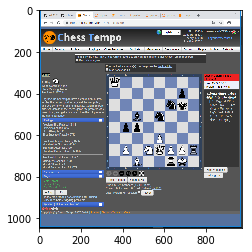

In [4]:

# See original image
#display_array(np.asarray(img), rng=[0,255])

imshow(np.asarray(img))

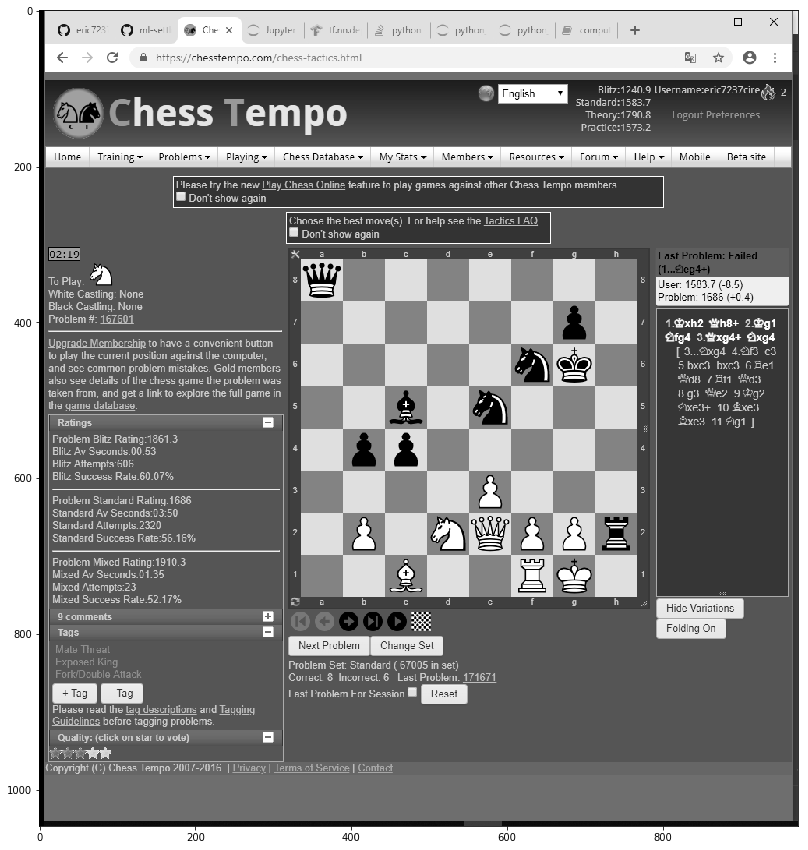

In [5]:
# Convert to grayscale and array
a = np.asarray(img.convert("L"), dtype=np.float32)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(np.asarray(a), cmap='gray')

import imageio
imageio.imwrite("file.png", a)


In [6]:
def make_kernel(a: List[List[float]]):
    """Transform a 2D array into a convolution kernel.
    TF needs the filter to be in 4d so this just appends 2 empty dimensions
    for channel & channel_multiplier
    """
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)


def simple_conv(x, k):
    """A simplified 2D convolution operation"""

    # add extra dimensions for batch # at beginning and channels at end (-1)
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    print(x)
    # data_format: The data format for input. Either "NHWC"
    # input 4-D with shape according to data_format
    # filter 4-D with shape [filter_height, filter_width, in_channels, channel_multiplier].
    y = tf.nn.depthwise_conv2d(input=x,
                               filter=k,

                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               data_format="NHWC"
                               )

    # chop off the batch and channels empty dimensions
    return y[0, :, :, 0]


def gradientx(x):
    """Compute the x gradient of an array"""
    gradient_x = make_kernel([[-1., 0., 1.],
                              [-1., 0., 1.],
                              [-1., 0., 1.]])
    return simple_conv(x, gradient_x)


def gradienty(x):
    """Compute the x gradient of an array"""
    gradient_y = make_kernel([[-1., -1, -1], 
                              [0., 0, 0], 
                              [1., 1, 1]])
    return simple_conv(x, gradient_y)


def corners(x):
    """Find chess square corners in an array"""
    chess_corner = make_kernel([[-1., 0, 1],
                                [0., 0., 0.],
                                [1., 0, -1]])
    return simple_conv(x, chess_corner)


# Following are meant for binary images
def dilate(x, size=3):
    """Dilate"""
    kernel = make_kernel(np.ones([size, size], dtype=np.float32))
    return tf.clip_by_value(simple_conv(x, kernel),
                            np.float32(1),
                            np.float32(2)) - np.float32(1)


def erode(x, size=3):
    """Erode"""
    kernel = make_kernel(np.ones([size, size]))
    return tf.clip_by_value(simple_conv(x, kernel),
                            np.float32(size * size - 1),
                            np.float32(size * size)) - np.float32(size * size - 1)


def opening(x, size=3):
    return dilate(erode(x, size), size)


def closing(x, size=3):
    return erode(dilate(x, size), size)


def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)


In [11]:

def simple_y(x):
    """An experiment to show the naive/simplest change detection"""
    gradient_y = make_kernel([[0, 1, 0], 
                              [0, -1, 0], 
                              [0, 0, 0]])
    return tf.abs(simple_conv(x, gradient_y))

clipped_a = a[200:,200:]

# Get our grayscale image matrix
A = tf.Variable(clipped_a)

# Get X & Y gradients and subtract opposite gradient
# Strongest response where gradient is unidirectional
# clamp into range 0-1
# Dx = tf.clip_by_value(np.abs(gradientx(A)) - np.abs(gradienty(A)),
#                       0., 1.)
# Dy = tf.clip_by_value(np.abs(gradienty(A)) - np.abs(gradientx(A)),
#                       0., 1.)

Dx = gradientx(A)
Dy = gradienty(A)
Dy2 = simple_y(A)

Tensor("ExpandDims_7:0", shape=(1, 847, 774, 1), dtype=float32)
Tensor("ExpandDims_9:0", shape=(1, 847, 774, 1), dtype=float32)
Tensor("ExpandDims_11:0", shape=(1, 847, 774, 1), dtype=float32)


[[216. 216. 216. ...  54.  55.  56.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ 88.  88.  88. ...   0.   0.   0.]
 ...
 [  1.   1.   1. ...   2.   0.   0.]
 [  1.   1.   1. ...   1.   1.   0.]
 [  0.   1.   1. ...   1.   2.   1.]]


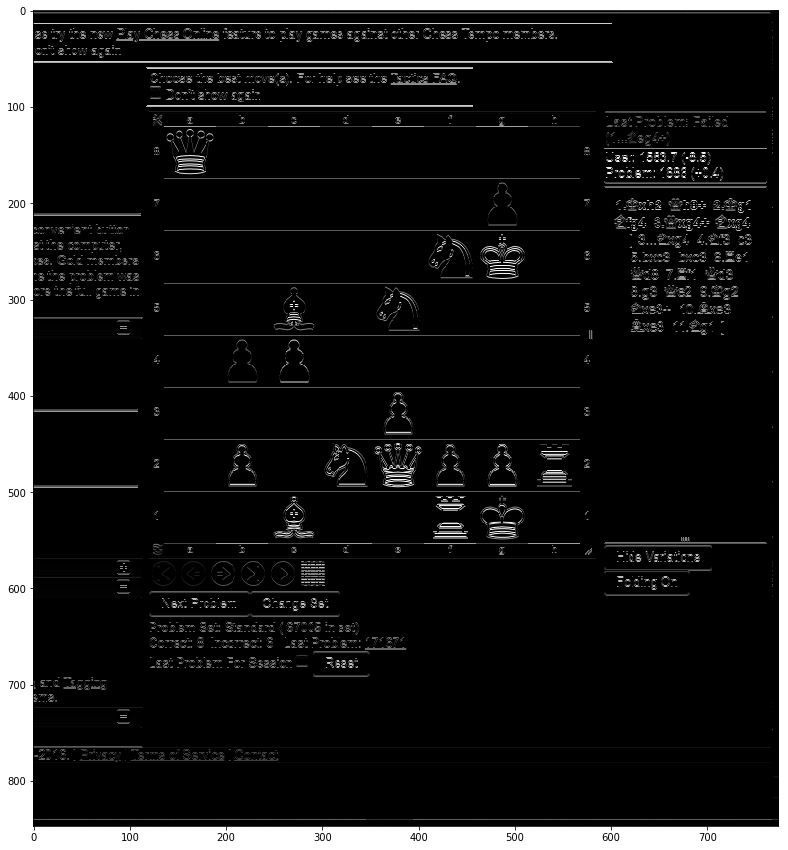

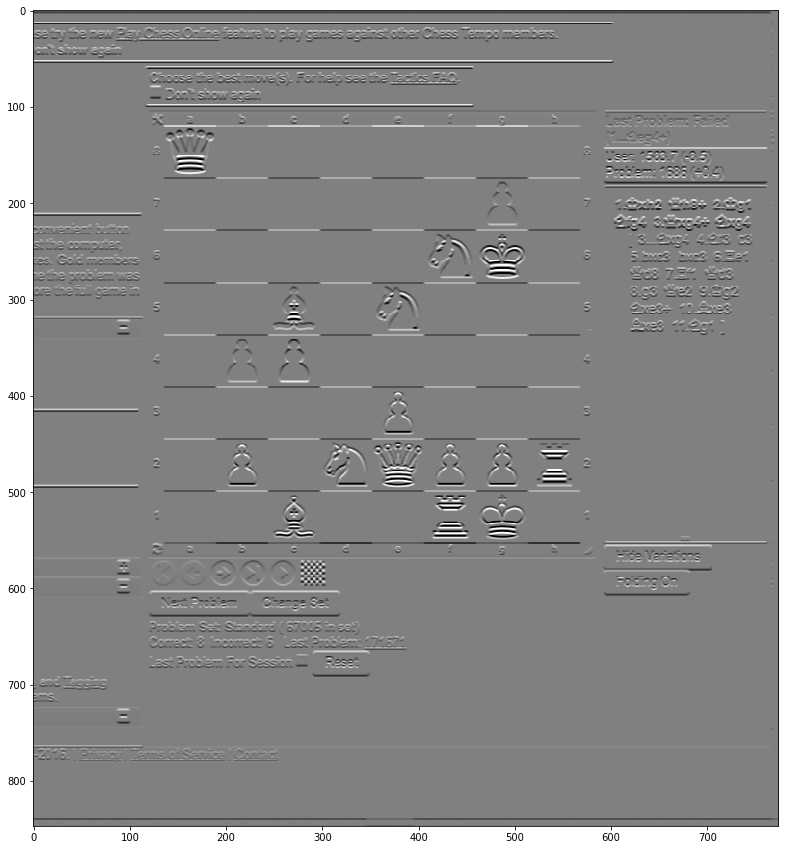

In [15]:


# Dxy = np.abs(gradientx(A) * gradienty(A))
# Dc = np.abs(corners(A))
#tf.global_variables_initializer().run()

# Initialize state to initial conditions
tf.global_variables_initializer().run()

#print(Dy2.eval())

#imageio.imwrite("file2.png", np.asarray(Dy2.eval()))
#imageio.imwrite("file3.png", np.asarray(Dy.eval()))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)

ax.imshow(Dy2.eval(), cmap='gray')

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(Dy.eval(), cmap='gray')


(2296,)
(180,)
(2296, 180)
(9,)
[347399 344519 206100 357839  55620 206819 358019  55440 206640]
(9,) (9,)
0 is =1929 Dist=179
1Angle=1.5707963267948966 Dist=781.8405228758172
1 is =1913 Dist=179
1Angle=1.5707963267948966 Dist=765.8335511982573
2 is =1145 Dist=0
1Angle=-1.5707963267948966 Dist=-2.5010893246187607
3 is =1987 Dist=179
1Angle=1.5707963267948966 Dist=839.8657952069718
4 is =309 Dist=0
1Angle=-1.5707963267948966 Dist=-838.8653594771242
5 is =1148 Dist=179
1Angle=1.5707963267948966 Dist=0.5002178649237976
6 is =1988 Dist=179
1Angle=1.5707963267948966 Dist=840.8662309368194
7 is =308 Dist=0
1Angle=-1.5707963267948966 Dist=-839.8657952069716
Angle=1.5707963267948966 Dist=840.8662309368194
Angle=1.5707963267948966 Dist=0.5002178649237976
Angle=1.5707963267948966 Dist=781.8405228758172
Angle=1.5707963267948966 Dist=765.8335511982573
Angle=1.5707963267948966 Dist=105.54596949891084
Angle=1.5707963267948966 Dist=569.7481481481482
Angle=1.5707963267948966 Dist=553.7411764705885
Ang

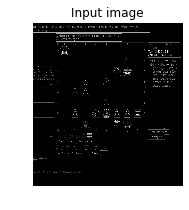

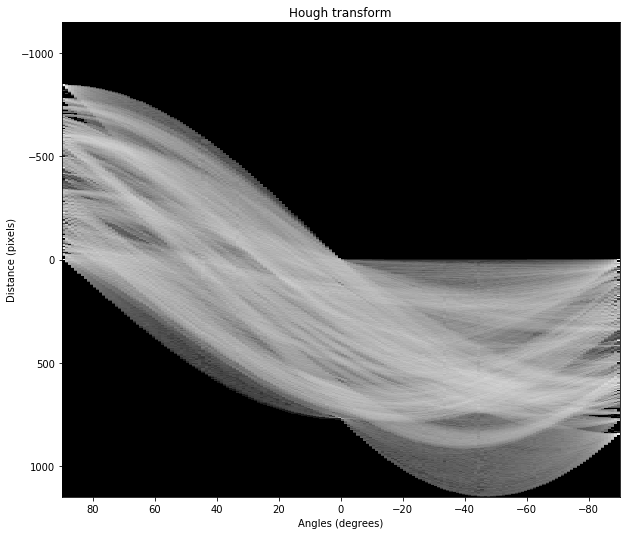

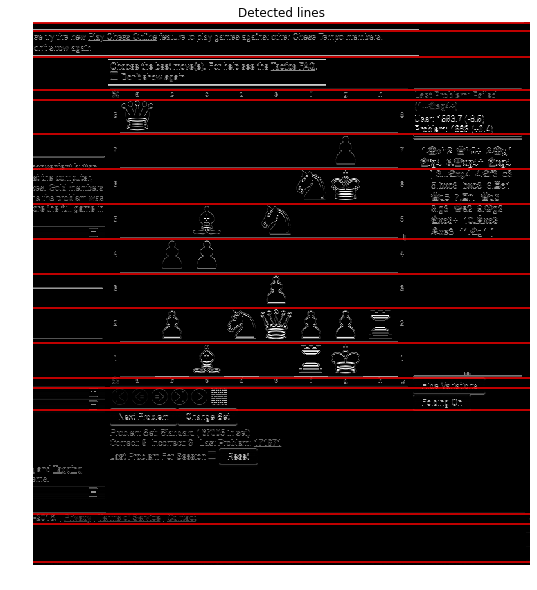

In [96]:
# Classic straight-line Hough transform
edge_image = Dy2.eval()
h, theta, d = hough_line(edge_image)

#print()

# Generating figure 1
fig, ax = plt.subplots(figsize=(3, 3)) 

ax.imshow(edge_image, cmap='gray')

ax.set_title('Input image')
ax.set_axis_off()

fig, ax = plt.subplots(figsize=(10, 10
                            )) 


ax.imshow(
    #np.random.random((300,300)),
    #image,
    np.log(1 + h),
             #scalars (left, right, bottom, top), optional
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap='gray', 
             aspect=1/15,
          
            )

ax.set_title('Hough transform')
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
#ax.axis('image')

#print(np.max(np.log(1+h), axis=1))


fig, ax = plt.subplots(figsize=(20, 10)) 

flat_indices = np.argpartition(h.ravel(), -9)[-9:]
print(d.shape)
print(theta.shape)
print(h.shape)
print(flat_indices.shape)
print(flat_indices)
row_indices, col_indices = np.unravel_index(flat_indices, h.shape)
print(row_indices.shape,col_indices.shape)
for i in range(0,row_indices.shape[0]-1):
    print(f"{i} is ={row_indices[i]} Dist={col_indices[i]}")
    print(f"1Angle={theta[col_indices[i]]} Dist={d[row_indices[i]]}")


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - edge_image.shape[1] * np.cos(angle)) / np.sin(angle)
    
    print(f"Angle={angle} Dist={dist}")
    
    ax.plot((0, edge_image.shape[1]), (y0, y1), '-r')
ax.set_xlim((0, edge_image.shape[1]))
ax.set_ylim((edge_image.shape[0], 0))
ax.set_axis_off()
ax.set_title('Detected lines')

ax.imshow(edge_image, cmap='gray')

In [8]:



Dx_pos = tf.clip_by_value(Dx, 0., 255., name="dx_positive")
Dx_neg = tf.clip_by_value(Dx, -255., 0., name='dx_negative')
Dy_pos = tf.clip_by_value(Dy, 0., 255., name="dy_positive")
Dy_neg = tf.clip_by_value(Dy, -255., 0., name='dy_negative')

hough_Dx = tf.reduce_sum(Dx_pos, 0) * tf.reduce_sum(-Dx_neg, 0) / (a.shape[0]*a.shape[0])
hough_Dy = tf.reduce_sum(Dy_pos, 1) * tf.reduce_sum(-Dy_neg, 1) / (a.shape[1]*a.shape[1])
# Normalized to 0-255*255=65025 range

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\kernelbase.py", line 359, in dispatch_queue
    yield self.process_one()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-20af13374526>", line 12, in <module>
    A = tf.Variable(clipped_a)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __init__
    constraint=constraint)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\array_ops.py", line 80, in identity
    return gen_array_ops.identity(input, name=name)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3264, in identity
    "Identity", input=input, name=name)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "e:\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable)]]


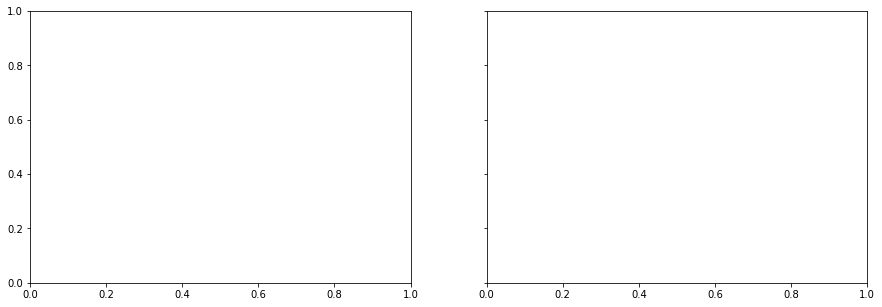

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

# Arbitrarily choose half of max value as threshold, since they're such strong responses
hough_Dx_thresh = tf.reduce_max(hough_Dx) * 3 / 5
hough_Dy_thresh = tf.reduce_max(hough_Dy) * 3 /5

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

In [ ]:
def checkMatch(lineset):
    """Checks whether there exists 7 lines of consistent increasing order in set of lines"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5

def pruneLines(lineset):
    """Prunes a set of lines to 7 in consistent increasing order (chessboard)"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i+2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            print(f"i={i}, x={x}")
            start_pos = i
    return lineset

def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh):
    """Returns pixel indices for the 7 internal chess lines in x and y axes"""
    # Blur
    gausswin = scipy.signal.gaussian(21,4)
    gausswin /= np.sum(gausswin)

    # Blur where there is a strong horizontal or vertical line (binarize)
    blur_x = np.convolve(hdx > hdx_thresh, gausswin, mode='same')
    blur_y = np.convolve(hdy > hdy_thresh, gausswin, mode='same')


    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Find points on skeletonized arrays (where returns 1-length tuple)
    lines_x = np.where(skel_x)[0] # vertical lines
    lines_y = np.where(skel_y)[0] # horizontal lines
    
    # Prune inconsistent lines
    lines_x = pruneLines(lines_x)
    lines_y = pruneLines(lines_y)
    
    is_match = len(lines_x) == 7 and len(lines_y) == 7 and checkMatch(lines_x) and checkMatch(lines_y)
    
    return lines_x, lines_y, is_match

# Get chess lines
lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval(), \
                                           hough_Dy_thresh.eval())

lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval()*.9, \
                                           hough_Dy_thresh.eval()*.9)

print(f"X {lines_x} {np.diff(lines_x)}")
print(f"Y {lines_y} {np.diff(lines_y)}")
if is_match:
    print ("Chessboard found")
else:
    print ("Couldn't find Chessboard")

In [ ]:
# Plot blurred 1d hough arrays and skeletonized versions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

# Plot lines for where peaks where found
if len(lines_x < 20):
    for hx in lines_x:
        ax1.axvline(hx,color='r')
if len(lines_y < 20):
    for hy in lines_y:
        ax2.axvline(hy,color='r')

In [ ]:
plt.imshow(img)
for hx in lines_x:
    plt.axvline(hx, color='b', lw=2)

for hy in lines_y:
    plt.axhline(hy, color='r', lw=2)

# Hello
